<a href="https://colab.research.google.com/github/HanselWilfred/WeatherWise-Hansel-Wilfred/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 🧪 Optional packages — uncomment if needed in Colab or JupyterHub
!pip install fetch-my-weather
!pip install requests matplotlib pyinputplus





  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyinputplus: filename=pyinputplus-0.2.12-py3-none-any.whl size=11348 sha256=cb03555e84d89fa8b8c3ddd3e80c22a38cd20da1eaae35d7844e566d94e381f2
  Stored in directory: /root/.cache/pip/wheels/85/81/c1/325c8199c5c4de8a0b9af900ff9cd8bd69853e3d9419493512
  Created wheel for pysimplevalidate: filename=pysimplevalidate-0.2.12-py3-none-any.whl size=16225 sha256=fcd3e0b607602a1c1e4939e8d088f4a83d68ff7c684ae7fb3abbd520455e7db7
  Stored in directory: /root/.cache/pip/wheels/09/de/18/4dd2be0dbdf31870c6f0abde43b0de197b1c095655ad7da5c2
  Created wheel for stdiomask: filename=stdiomask

## 📦 Setup and Configuration
Import required packages and setup environment.

In [2]:
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip
# ✅ Import after installing (if needed)
from fetch_my_weather import get_weather

# Add any other setup code here

## 🌤️ Weather Data Functions

In [3]:
# === Section 1: Data Fetching ===
import re, requests
from datetime import datetime

def format_date(d: str) -> str:
    try:
        return datetime.strptime(d, "%Y-%m-%d").strftime("%d %b %Y")
        # use "%d %B %Y" for full month name
    except Exception:
        return d


def get_weather_data(place: str, rain_threshold: int = 30):
    """
    On success:
      {
        "location": str,
        "current_temp": float|None,
        "forecast": [
          {"date": str, "max_temp": float|None, "min_temp": float|None,
           "rain_chance": float|None, "emoji": str, "rain_text": str}
        ],
        "summary": [str, ...]
      }
    Or: {"error": "message"}
    """
    def _clean(s: str | None) -> str | None:
        if not s: return None
        s = re.sub(r"\b(tomorrow|today|day after|in\s+\d+\s+days)\b", "", s, flags=re.I)
        s = re.sub(r"\s+", " ", s).strip()
        return s or None

    def _emoji(t):
        try: t = float(t)
        except (TypeError, ValueError): return ""
        return "🔥" if t >= 35 else ("🙂" if t >= 15 else "🥶")

    loc = _clean(place)
    if not loc:
        return {"error": "Please enter a valid city or PIN/ZIP."}

    try:
        # Geocode
        r = requests.get(
            "https://geocoding-api.open-meteo.com/v1/search",
            params={"name": loc, "count": 1, "language": "en"},
            timeout=10
        ); r.raise_for_status()
        hits = (r.json().get("results") or [])
        if not hits:
            return {"error": f"Could not find '{loc}'. Please try another place."}
        lat, lon = hits[0]["latitude"], hits[0]["longitude"]
        city = hits[0].get("name") or loc

        # Forecast + current
        r = requests.get(
            "https://api.open-meteo.com/v1/forecast",
            params={
                "latitude": lat, "longitude": lon, "timezone": "auto",
                "current_weather": True,
                "daily": "temperature_2m_max,temperature_2m_min,precipitation_probability_max",
            },
            timeout=10
        ); r.raise_for_status()
        data = r.json()
        daily = data.get("daily") or {}
        dates = daily.get("time") or []
        if not dates:
            return {"error": "No forecast available right now. Try again later."}

        tmax  = daily.get("temperature_2m_max") or []
        tmin  = daily.get("temperature_2m_min") or []
        rainp = daily.get("precipitation_probability_max") or []
        n = min(5, len(dates))

        rows, summary = [], [f"5-day forecast for {city}:"]
        for i in range(n):
            mx = tmax[i]  if i < len(tmax)  else None
            mn = tmin[i]  if i < len(tmin)  else None
            rc = rainp[i] if i < len(rainp) else None
            emo = _emoji(mx if mx is not None else mn)
            rain_txt = f"(rain {int(rc)}%)" if isinstance(rc, (int, float)) and rc >= rain_threshold else ""
            rows.append({"date": dates[i], "max_temp": mx, "min_temp": mn,
                         "rain_chance": rc, "emoji": emo, "rain_text": rain_txt})
            temp_txt = f"{round(mx)}°C {emo}" if mx is not None else "temp N/A"
            summary.append(f"{dates[i]}: {temp_txt} {rain_txt}".rstrip())

        return {
            "location": city,
            "current_temp": (data.get("current_weather") or {}).get("temperature"),
            "forecast": rows,
            "summary": summary
        }

    except (requests.ConnectionError, requests.Timeout):
        return {"error": "No internet connection. Please connect to Wi-Fi or mobile data."}
    except requests.RequestException:
        return {"error": "Something went wrong while fetching the weather."}




## 📊 Visualisation Functions

In [4]:
# === UI (A): helpers & visualisations (REPLACE WHOLE CELL) ===

def print_forecast(result: dict):
    if "error" in result:
        print(f"⚠️ {result['error']}"); return
    print(f"📍 {result['location']} | 🌡️ {result.get('current_temp','N/A')}°C")
    for f in result["forecast"]:
        pick = f["max_temp"] if f["max_temp"] is not None else f["min_temp"]
        emoji = "🔥" if (pick is not None and pick >= 35) else ("🙂" if (pick is not None and pick >= 15) else "🥶")
        fd = format_date(f['date'])  # <-- formatted date
        if f["min_temp"] is not None and f["max_temp"] is not None:
            line = f"{fd}: {f['min_temp']:.1f}–{f['max_temp']:.1f}°C {emoji}"
        elif f["max_temp"] is not None:
            line = f"{fd}: {f['max_temp']:.1f}°C {emoji}"
        else:
            line = f"{fd}: temp N/A {emoji}"
        if f.get("rain_text"): line += f" {f['rain_text']}"
        print(line)

def create_temperature_visualisation(result: dict):
    """Shaded min–max band + lines."""
    if "error" in result or not result.get("forecast"):
        print("No data to visualise."); return
    try:
        import matplotlib.pyplot as plt
    except Exception:
        print("📉 Matplotlib not available."); return
    fc = result["forecast"]
    xs = list(range(len(fc)))
    dates = [format_date(r["date"]) for r in fc]  # <-- formatted dates
    tmin  = [r["min_temp"] for r in fc]
    tmax  = [r["max_temp"] for r in fc]
    plt.figure(figsize=(8,4.5))
    plt.fill_between(xs, tmin, tmax, alpha=0.25, label="Daily range")
    plt.plot(xs, tmax, marker="o", label="Max (°C)")
    plt.plot(xs, tmin, marker="o", label="Min (°C)")
    plt.title(f"Temperature (Min–Max) — {result['location']}")
    plt.xlabel("Day"); plt.ylabel("°C"); plt.xticks(xs, dates)
    plt.grid(True, linestyle="--", alpha=0.5); plt.legend(); plt.tight_layout(); plt.show()






In [5]:

# ------------------------------
# 2) Rain "lollipop" chart: stem + circle with % label
def create_precipitation_visualisation(result: dict):
    """Rain chance lollipop chart."""
    if "error" in result or not result.get("forecast"):
        print("No data to visualise."); return
    try:
        import matplotlib.pyplot as plt
    except Exception:
        print("📉 Matplotlib not available."); return
    fc = result["forecast"]
    xs = list(range(len(fc)))
    dates = [format_date(r["date"]) for r in fc]  # <-- formatted dates
    rainp = [r["rain_chance"] if isinstance(r["rain_chance"], (int, float)) else 0 for r in fc]
    plt.figure(figsize=(8,4.5))
    for x, v in zip(xs, rainp):
        plt.vlines(x, 0, v, linewidth=2)
        plt.scatter(x, v, s=60, zorder=3)
        plt.text(x, v + 2, f"{int(v)}%", ha="center", fontsize=8)
    plt.title(f"Rain Chance — {result['location']}")
    plt.xlabel("Day"); plt.ylabel("Rain Chance (%)"); plt.xticks(xs, dates)
    plt.ylim(0, 100); plt.grid(axis="y", linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()


## 🤖 Natural Language Processing

In [6]:
# === Section 2: NLP + Response ===

# === Section 2: NLP + Response (with formatted dates) ===
import re

def _clean_location(text: str) -> str | None:
    if not text: return None
    text = re.sub(r"\b(tomorrow|today|day after|in\s+\d+\s+days)\b", "", text, flags=re.I)
    text = re.sub(r"\s+", " ", text).strip()
    return text.title() if text else None

def parse_weather_question(q: str):
    q = (q or "").lower().strip()

    # Day: today=0, tomorrow=1, day after=2, or "in N days" clamped 0..4
    day = 2 if "day after" in q else 1 if "tomorrow" in q else 0
    m = re.search(r"\bin\s+(\d+)\s+days\b", q)
    if m:
        day = max(0, min(4, int(m.group(1))))

    # Attribute: rain-only if rain words; temperature-only if temp words; else general
    if any(w in q for w in ["rain","umbrella","drizzle","shower"]):
        attr = "rain"
    elif any(w in q for w in ["temp","temperature","hot","cold","warm","cool","chill"]):
        attr = "temperature"
    else:
        attr = "general"

    # Location: PIN/ZIP first
    pin = re.search(r"\b\d{3,6}\b", q)
    if pin:
        return {"location": pin.group(0), "day": day, "attribute": attr}

    # Or words after "in ..." (stop before punctuation/time words)
    m = re.search(
        r"\bin\s+([a-z0-9\s\-]+?)(?=(?:\?|\.|,|$|\s+tomorrow|\s+today|\s+day after|\s+in\s+\d+\s+days))",
        q
    )
    loc = _clean_location(m.group(1)) if m else None
    return {"location": loc, "day": day, "attribute": attr}

def generate_weather_response(user_question: str, fetch_fn):
    """
    fetch_fn(place) -> {"error":"..."} or {"location":..., "forecast":[{date,max_temp,min_temp,rain_chance},...]}
    """
    info = parse_weather_question(user_question)
    place, day, attr = info["location"], info["day"], info["attribute"]
    if not place:
        return "Please tell me a city or PIN/ZIP (e.g., 'weather in Perth')."

    data = fetch_fn(place)
    if "error" in data:
        return data["error"]

    fc = data.get("forecast") or []
    if not fc:
        return "No forecast available right now."

    # Choose the requested day (clamped)
    i = min(day, len(fc) - 1)
    row = fc[i]
    city = data.get("location", place)
    date = row.get("date", "that day")
    date = format_date(date)  # <-- format date as DD Mon YYYY

    mx, mn, rc = row.get("max_temp"), row.get("min_temp"), row.get("rain_chance")
    t = mx if mx is not None else mn

    # 35+ hot, 15..34 cool, <15 cold
    def temp_phrase(x):
        if x is None: return "temperature unavailable"
        return "hot and sunny" if x >= 35 else ("cool and pleasant" if x >= 15 else "cold")

    def rain_only(x):
        if x is None: return "No rain info."
        return ("Yes, likely — rain "+str(int(x))+"%.") if x >= 50 else \
               ("Possible — rain "+str(int(x))+"%.") if x >= 20 else \
               ("Unlikely — rain "+str(int(x))+"%.")

    if attr == "rain":
        return f"In {city} on {date}: {rain_only(rc)}"
    elif attr == "temperature":
        msg = f"In {city} on {date}: {temp_phrase(t)}"
        msg += f" (around {round(t)}°C)" if t is not None else ""
        if isinstance(rc,(int,float)) and rc >= 30:
            msg += f", rain {int(rc)}%."
        else:
            msg += "."
        return msg
    else:  # general
        msg = f"In {city} on {date}: {temp_phrase(t)}"
        msg += f" (around {round(t)}°C)" if t is not None else ""
        if isinstance(rc,(int,float)) and rc >= 30:
            msg += f"; rain {int(rc)}%."
        else:
            msg += "."
        return msg


## 🧭 User Interface

In [7]:
# === UI (A): helpers & visualisations ===

def print_forecast(result: dict):
    if "error" in result:
        print(f"⚠️ {result['error']}"); return
    print(f"📍 {result['location']} | 🌡️ {result.get('current_temp','N/A')}°C")
    for f in result["forecast"]:
        pick = f["max_temp"] if f["max_temp"] is not None else f["min_temp"]
        emoji = "🔥" if (pick is not None and pick >= 35) else ("🙂" if (pick is not None and pick >= 15) else "🥶")
        fd = format_date(f['date'])  # add this line
        if f["min_temp"] is not None and f["max_temp"] is not None:
            line = f"{f['date']}: {f['min_temp']:.1f}–{f['max_temp']:.1f}°C {emoji}"
        elif f["max_temp"] is not None:
            line = f"{f['date']}: {f['max_temp']:.1f}°C {emoji}"
        else:
            line = f"{f['date']}: temp N/A {emoji}"
        if f.get("rain_text"): line += f" {f['rain_text']}"
        print(line)

def create_temperature_visualisation(result: dict):
    """Shaded min–max band + lines."""
    if "error" in result or not result.get("forecast"):
        print("No data to visualise."); return
    try:
        import matplotlib.pyplot as plt
    except Exception:
        print("📉 Matplotlib not available."); return
    fc = result["forecast"]
    xs = list(range(len(fc)))
    dates = [r["date"] for r in fc]
    tmin  = [r["min_temp"] for r in fc]
    tmax  = [r["max_temp"] for r in fc]
    plt.figure(figsize=(8,4.5))
    plt.fill_between(xs, tmin, tmax, alpha=0.25, label="Daily range")
    plt.plot(xs, tmax, marker="o", label="Max (°C)")
    plt.plot(xs, tmin, marker="o", label="Min (°C)")
    plt.title(f"Temperature (Min–Max) — {result['location']}")
    plt.xlabel("Day"); plt.ylabel("°C"); plt.xticks(xs, dates)
    plt.grid(True, linestyle="--", alpha=0.5); plt.legend(); plt.tight_layout(); plt.show()

def create_precipitation_visualisation(result: dict):
    """Rain chance lollipop chart."""
    if "error" in result or not result.get("forecast"):
        print("No data to visualise."); return
    try:
        import matplotlib.pyplot as plt
    except Exception:
        print("📉 Matplotlib not available."); return
    fc = result["forecast"]
    xs = list(range(len(fc)))
    dates = [r["date"] for r in fc]
    rainp = [r["rain_chance"] if isinstance(r["rain_chance"], (int, float)) else 0 for r in fc]
    plt.figure(figsize=(8,4.5))
    for x, v in zip(xs, rainp):
        plt.vlines(x, 0, v, linewidth=2)
        plt.scatter(x, v, s=60, zorder=3)
        plt.text(x, v + 2, f"{int(v)}%", ha="center", fontsize=8)
    plt.title(f"Rain Chance — {result['location']}")
    plt.xlabel("Day"); plt.ylabel("Rain Chance (%)"); plt.xticks(xs, dates)
    plt.ylim(0, 100); plt.grid(axis="y", linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()

def create_both_visualisations(result: dict):
    """Show temperature chart, then rain chart."""
    create_temperature_visualisation(result)
    create_precipitation_visualisation(result)

In [8]:
# === UI (B): main menu loop ===
def run_app():
    print("🌦️ Welcome to WeatherWise 🌦️")
    print("👉 You can enter either a city name OR a PIN/ZIP code.")
    while True:
        print("\nPlease select one of the following:")
        print("1. View Forecast")
        print("2. Ask a Question")
        print("3. Visualise Data")
        print("4. Exit")
        choice = input("> ").strip()

        if choice == "1":
            place = input("Enter a city or PIN/ZIP: ").strip()
            result = get_weather_data(place)
            print_forecast(result)

        elif choice == "2":
            q = input("Ask about the weather: ").strip()  # e.g., "Temperature in Adelaide in 3 days?"

            # Try to extract location from the question
            info = parse_weather_question(q)
            place = info.get("location")

            if not place:
                # Ask only if the question didn't include a city/PIN
                place = input("City or PIN/ZIP: ").strip()
                q_full = f"{q} in {place}"
            else:
                q_full = q  # already includes a location

            # Use your existing function (no adapter)
            print(generate_weather_response(q_full, get_weather_data))

        elif choice == "3":
            place = input("Enter a city to visualise: ").strip()
            result = get_weather_data(place)
            if "error" in result:
                print(f"⚠️ {result['error']}")
                continue

            print("Visualise: 1) Temperature  2) Rain Chance  3) Both")
            v = input("> ").strip().lower()
            if v in ("1", "temp", "temperature"):
                create_temperature_visualisation(result)
            elif v in ("2", "rain", "precipitation"):
                create_precipitation_visualisation(result)
            elif v in ("3", "both", "all"):
                try:
                    create_both_visualisations(result)
                except NameError:
                    create_temperature_visualisation(result)
                    create_precipitation_visualisation(result)
            else:
                print("Choose 1, 2, or 3.")

        elif choice == "4":
            print("Goodbye! ☀️")
            break
        else:
            print("Please choose 1–4.")



## 🧩 Main Application Logic

In [11]:
# Tie everything together here
def run_app():
    print("🌦️ Welcome to WeatherWise 🌦️")
    print("👉 Enter a city (Perth) or PIN/ZIP (6000).")
    while True:
        print("\n1) View Forecast  2) Ask a Question  3) Visualise  4) Exit")
        choice = input("> ").strip()

        if choice == "1":
            res = get_weather_data(input("Enter a city: ").strip())
            print_forecast(res)

        elif choice == "2":
            q = input("Ask about the weather: ").strip()         # e.g. "will it rain tomorrow?"
            place = input("City or PIN/ZIP: ").strip()           # e.g. "Perth"
            print(generate_weather_response(f"{q} in {place}", get_weather_data))

        elif choice == "3":
            res = get_weather_data(input("City to visualise: ").strip())
            if "error" in res:
                print(f"⚠️ {res['error']}"); continue
            v = input("1) Temperature  2) Rain  3) Both > ").strip().lower()
            if v in ("1","temp","temperature"): create_temperature_visualisation(res)
            elif v in ("2","rain","precip","precipitation"): create_precipitation_visualisation(res)
            elif v in ("3","both","all"): create_both_visualisations(res)
            else: print("Choose 1, 2, or 3.")

        elif choice == "4":
            print("Goodbye! ☀️")
            break
        else:
            print("Please choose 1–4.")

## 🧪 Testing and Examples

🌦️ Welcome to WeatherWise 🌦️
👉 Enter a city (Perth) or PIN/ZIP (6000).

1) View Forecast  2) Ask a Question  3) Visualise  4) Exit
> 3
City to visualise: Reno
1) Temperature  2) Rain  3) Both > 3


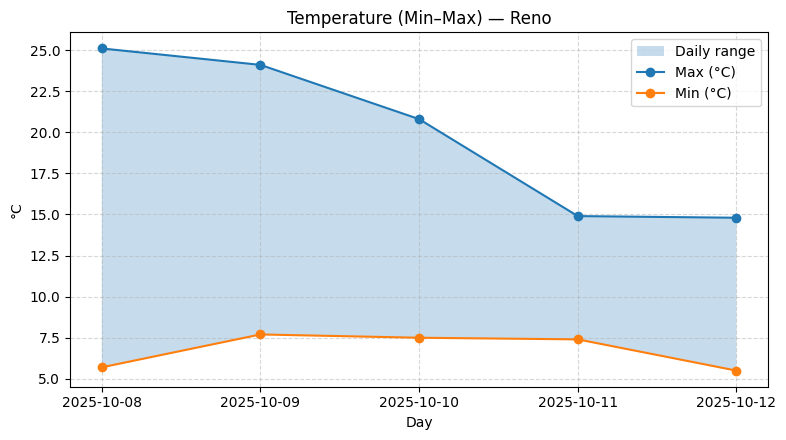

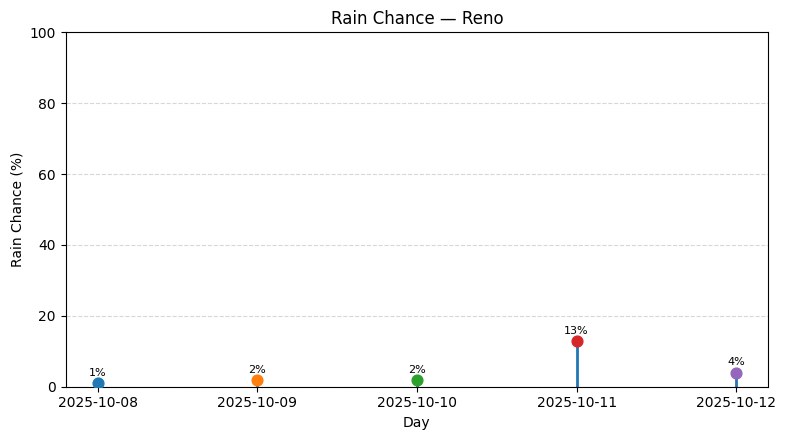


1) View Forecast  2) Ask a Question  3) Visualise  4) Exit
> 4
Goodbye! ☀️


In [13]:
4
# Questions you can ask weatherwise
SAMPLE_QUESTIONS = [
    # Rain-only
    "Will it rain today?",
    "Is rain likely in Chennai tomorrow?",

    # Temperature-only
    "Is it cold tomorrow in Melbourne?",
    "Temperature in Adelaide?",

    # General feel
    "How is the weather?",
    "Weather in Auckland in 4 days?",
]

run_app()